# 异常监测和协同过滤(Anomaly Detection and Collaborative Filtering)

## 项目背景

#### 项目背景：
* 1.项目基于吴恩达教授的《机器学习》课程。
* 2.数据均来源于课程配套资料。


#### 项目目的：
* 1、学习协方差估计异常监测模型
* 2、学习协同过滤推荐系统模型
* 3、利用协方差估计检测故障服务器
* 4、利用协同过滤构建电影推荐系统

# 导入相关的库

In [2]:
import numpy as np
import pandas as pd

import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import iplot,init_notebook_mode
cf.go_offline(connected=True)
init_notebook_mode(connected=True)

import scipy.io as sio #因为是mat文件，需要用scipy导入

# 1.协方差估计异常检测

In [7]:
data = sio.loadmat(r'dataset（数据集）\ex8data1.mat')
X = data['X']
X.shape

(307, 2)

In [8]:
# 看一下数据分布
fig = px.scatter(x=X[:,0], y=X[:,1])
fig.update_layout(height=500,width=500,xaxis=dict(title='X1'),yaxis=dict(title='X2'))
fig.show()

In [9]:
# 看一下已验证数据
Xval = data['Xval']
yval = data['yval']# 0表示无异常，1表示异常

In [10]:
# 看一下数据异常比例
np.sum(yval)/yval.size
print('数据异常比例：',round((np.sum(yval)/yval.size)*100,2),'%')

数据异常比例： 2.93 %


In [11]:
# 看一下验证数据分布
fig = px.scatter(x=Xval[:,0], y=Xval[:,1],color=yval)
fig.update_layout(height=500,width=500,xaxis=dict(title='X1'),yaxis=dict(title='X2'))
fig.show()

* 从图中发现有两个离群点出现在了内群点集中的地方。实际工作中需要对这两个点重新分析，增加更多的判断特征。

## 1.1.自定义函数

In [14]:
# 定义mu和sigma
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [15]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

In [16]:
# 计算概率密度p
from scipy import stats
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

print(p.shape)

pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

print(pval.shape)

(307, 2)
(307, 2)


我们通过计算f1分数找到最合适的阈值，f1计算公式为：$$F_1 Score = 2 * PR/(P+R)$$
其中P表示查准率（Precision），即预测为1的准确率；R表示查全率（Recall），即预测为1占实际为1的比率。

In [17]:
# 找到最优的f1分数和阈值
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)# 计算预测为1，实际为1的数量（True Positive）
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)# 计算预测为1，实际为0的数量（False Positive）
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)# 计算预测为0，实际为1的数量（False Negative）
        
        precision = tp / (tp + fp) # 计算查准率
        recall = tp / (tp + fn) # 计算查全率
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [18]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

invalid value encountered in double_scalars



(0.009566706005956842, 0.7142857142857143)

* 由此我们知道最优的概率阈值为0.009

In [19]:
# 计算异常值索引
outliers = np.where(p < epsilon)
outliers # 得到索引(300,1)、(301,1)...

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

In [20]:
# 我们来看一下检测结果
trace1 = go.Scatter(x = X[:,0].tolist(), y = X[:,1].tolist(),mode='markers', name = '无异常')
trace2 = go.Scatter(x = X[outliers[0],0].tolist(), y = X[outliers[0],1].tolist(),mode='markers', name = '异常值')
fig = go.Figure(data=[trace1,trace2])
fig.update_layout(height=500,width=500,xaxis=dict(title='X1'),yaxis=dict(title='X2'))
fig.show()

## 1.2.调用sklearn函数

In [21]:
from sklearn.covariance import EllipticEnvelope
AD = EllipticEnvelope(contamination=0.02,random_state = 0) # 包含离群点的百分比设为0.02

In [22]:
y_pred=AD.fit_predict(Xval)

* 内围点被标记为1，而离群点/异常值被标记为-1

In [23]:
# 将yval里的0替换成1
yval=np.where(yval==0,1,-1)

In [24]:
# 用混淆矩阵计算准确率
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(yval,y_pred)
cm

array([[  7,   2],
       [  0, 298]], dtype=int64)

* 有两个点预测错误，犯了FN错误，即预测为无异常而实际上异常。
* 很明显，这两个点即之前我们可视化过程发现的位于内群点聚集圈的点。

In [25]:
y_pred2=AD.fit_predict(X)

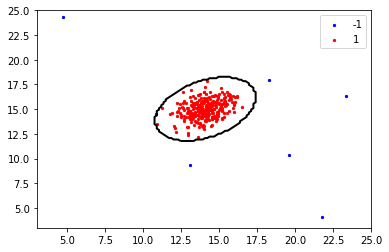

In [27]:
# 可视化异常检测结果
import matplotlib.pyplot as plt
xx, yy = np.meshgrid(np.linspace(3, 25, 150),
                     np.linspace(3, 25, 150))
Z = AD.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')
for i,j in enumerate(np.unique(y_pred)):
    plt.scatter(X[y_pred2==j,0],X[y_pred2==j,1],label = j,c=['blue','red'][i],s=5)
plt.legend()
plt.show()

* 这个预测结果和我们自定义函数的分析结果类似。

# 2.协同过滤推荐系统

## 2.1.导入相关文件

In [28]:
# 导入电影的评分文件
data = sio.loadmat(r'dataset（数据集）\ex8_movies.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [29]:
Y = data['Y']
R = data['R']
Y.shape,R.shape

((1682, 943), (1682, 943))

从中可知：
* 用户实际评分为Y，共有1682部电影，合计943个用户进行评分。
* 用户是否评分为R，已评分记为1，未评分记为0。

In [30]:
# 我们来看一下评分状况
pd.DataFrame(R).apply(lambda x : x.sum(),axis=1).describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
dtype: float64

* 可知1682部电影都有用户评分，最少1人评分，最多583人评分。
* Y不足时，模型训练得到的X和theta都可能存在过度拟合的情况。
* 根据该数据集训练得到X和theta还将随着评分人数的增加而优化。

In [31]:
# 我们来看一下每部电影的平均评分
ave = []
for i in np.arange(0,1682):
    temp = Y[i,np.where(R[i,:]==1)[0]].mean()
    ave.append(temp)
np.mean(ave),np.max(ave),np.min(ave) # 全部电影的平均评分

(3.076044508325179, 5.0, 1.0)

* 最低分为1分，最高分为5分，均值为3分，评分状况良好。

In [32]:
# 导入初始化参数文件
param_initial = sio.loadmat(r'dataset（数据集）\ex8_movieParams.mat')
theta =param_initial['Theta']
X =param_initial['X']

theta.shape, X.shape

((943, 10), (1682, 10))

* 可知我们设置了10个特征，实际上我们可以多设置一些，以提高模型准确度。

In [33]:
# 导入电影目录
txt = pd.read_csv(r'dataset（数据集）\movie_ids.txt',
                  sep='/r', header=None,engine="python")
movielist=[]
for i in txt.iloc[:,0].values:
    temp = i.split(' ')
    movielist.append(' '.join(temp[1:]))
movielist = np.array(movielist)
movielist

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype='<U81')

## 2.2.定义相关函数

### 2.2.1.定义参数函数

In [34]:
# 将参数X和theta扁平化（flatten），以便之后的计算
def param_flatten(X, theta):
    param = np.concatenate((X.ravel(), theta.ravel()))
    return param

In [35]:
# 将参数X和theta分开
def param_separate(param, n_movie, n_user, n_features=10): # 特征数设置默认为10
    X = param[:n_movie * n_features].reshape(n_movie, n_features)
    theta = param[n_movie * n_features:].reshape(n_user, n_features)
    return X, theta

In [36]:
# 我们来检验一下函数有没有问题
param = param_flatten(X, theta)
print(param.shape)
param_separate(param, 1682, 943)

(26250,)


(array([[ 1.0486855 , -0.40023196,  1.19411945, ...,  0.861721  ,
         -0.69728994,  0.28874563],
        [ 0.78085123, -0.38562591,  0.52119779, ...,  0.70402073,
         -0.48583521, -0.56462407],
        [ 0.64150886, -0.54785385, -0.08379638, ...,  0.83854643,
         -0.69483208, -1.13479631],
        ...,
        [ 0.21952237, -0.20047886,  0.09257965, ...,  0.14595183,
         -0.0431316 ,  0.17830451],
        [ 0.16044028, -0.16015395,  0.23570946, ...,  0.2073381 ,
         -0.33234766,  0.0428813 ],
        [ 0.07677118, -0.19720738,  0.08186445, ...,  0.40012757,
         -0.28747906, -0.03233498]]),
 array([[ 0.28544362, -1.68426509,  0.26293877, ...,  0.76723235,
         -1.10460164, -0.25186708],
        [ 0.50501321, -0.45464846,  0.31746244, ...,  1.09306336,
         -1.20029436, -0.39161676],
        [-0.43191656, -0.47880449,  0.84671111, ...,  1.36333976,
         -0.32523542, -0.19468212],
        ...,
        [ 1.0586926 , -0.8087176 ,  0.56935771, ...,  

### 2.2.2.定义代价函数
$$J(x^{(1)},…x^{(n_m)},\theta^{(1)},…,\theta^{(n_u)})=\frac{1}{2} \sum_{(i:j):r(i,j)=1}(x^{(i)}{\theta^{(j)}}^T -y^{(i,j)})^2+\frac{λ}{2}{\sum_{i=1}^{n_m}}{\sum_{k=1}^n}( x_k^{(j)})^2+\frac{λ}{2} {\sum_{i=1}^{n_u}}{\sum_{k=1}^n}( \theta_k^{(j)})^2$$

In [427]:
# 定义正则化代价函数
def reg_cost(param, Y, R, n_features=10, reg_lambda=1): # 正则化参数设置默认为1，特征数设置默认为10
    
    # 定义代价(计算R=1的代价)
    n_movie, n_user = Y.shape
    X, theta = param_separate(param, n_movie, n_user, n_features)
    cost = (np.power(np.multiply(X @ theta.T - Y, R), 2).sum())/2
    
    # 计算正则化部分(param为扁平化的X和theta)
    reg_term = np.power(param, 2).sum() * (reg_lambda / 2)

    return cost + reg_term

In [428]:
# 我们来看一下函数有没有问题
reg_cost(param, Y, R)

32520.682450229557

### 2.2.3.定义梯度下降函数
$$x_k^{(i)}:=x_k^{(i)}-\alpha(\sum_{j:r(i,j)=1}((x^{(i)} {\theta^{(j)}}^T -y^{(i,j)}) \theta_k^j+\lambda x_k^{(i)})$$
$$\theta_k^{(i)}:=\theta_k^{(i)}-\alpha(\sum_{j:r(i,j)=1}((x^{(i)} {\theta^{(j)}}^T-y^{(i,j)})x_k^i+\lambda \theta_k^{(i)})$$
* 在这里我们定义的仅是步长部分，即:
$$(x^{(i)} {\theta^{(j)}}^T -y^{(i,j)}) \theta_k^j+\lambda x_k^{(i)}$$
$$( x^{(i)} {\theta^{(j)}}^T-y^{(i,j)}) x_k^i+\lambda \theta_k^{(i)}$$

In [429]:
# 定义梯度下降的步长函数
def reg_gradient(param, Y, R, n_features=10, reg_lambda=1):
    
    n_movies, n_user = Y.shape
    X, theta = param_separate(param, n_movies, n_user, n_features)
    
    # 计算括号内容
    temp = np.multiply(X @ theta.T - Y, R)

    # 计算X的步长
    X_grad = temp @ theta
    X_grad += reg_lambda * X # 正则化

    # 计算theta的步长
    theta_grad = temp.T @ X
    theta_grad += reg_lambda * theta # 正则化

    # 将步长扁平化
    return param_flatten(X_grad, theta_grad)

In [430]:
# 我们来看一下函数有没有问题
reg_gradient(param, Y, R)

array([-5.21315594,  2.0591285 , -5.68148384, ..., -5.27650042,
        4.22109195,  2.11819114])

## 2.3.创建我的数据

In [431]:
# 创建我的电影评分记录（注：评分在1-5之间）
ratings = np.zeros(1682)

ratings[0] = 3
ratings[8] = 4
ratings[22] = 3
ratings[33] = 5
ratings[55] = 3
ratings[66] = 4
ratings[123] = 2
ratings[230] = 2
ratings[234] = 5
ratings[588] = 4
ratings[699] = 3

In [432]:
# 把我的电影评分记录加入到Y和R中
Y = np.insert(Y, 0, ratings, axis=1)  # 插入第一列
R = np.insert(R, 0, ratings != 0, axis=1)
Y.shape, R.shape

((1682, 944), (1682, 944))

In [433]:
# 对Y进行特征缩放
Y_norm = Y - Y.mean()
Y.mean()

0.22233418650113868

In [434]:
# 重新初始化X和theta，设置100个特征（10个还是太少了呀）
X = np.random.standard_normal((1682, 100))
theta = np.random.standard_normal((944, 100)) #加上我的评分，n_user变成了944

X.shape, theta.shape

((1682, 100), (944, 100))

In [435]:
# 将X和theta扁平化
param = param_flatten(X, theta)

## 2.4.训练模型并预测

In [436]:
import scipy.optimize as opt

In [437]:
model = opt.minimize(fun=reg_cost,
                   x0=param,
                   args=(Y_norm, R, 100, 10),# 特征增加，为避免过度拟合，正则化参数设置为10
                   method='TNC',
                   jac=reg_gradient)

In [438]:
model

     fun: 64103.801781535134
     jac: array([-7.46946052e-08,  3.69384260e-06,  4.92585426e-07, ...,
        3.16879618e-07,  5.31186861e-07,  3.33514946e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1485
     nit: 50
  status: 1
 success: True
       x: array([-0.12242139, -0.04650096,  0.26183899, ...,  0.14236999,
        0.17713193,  0.02918315])

In [439]:
# 分离训练得到X和theta
X_trained, theta_trained = param_separate(model.x, 1682, 944, 100)
X_trained.shape, theta_trained.shape

((1682, 100), (944, 100))

In [440]:
# 预测我的评分（注：我的评分是Y的第一列）
prediction = X_trained @ theta_trained.T
my_prediction = prediction[:,0] + Y.mean()
my_prediction

array([2.94275097, 2.01562469, 2.02647639, ..., 0.46798812, 0.46487474,
       0.61550778])

In [441]:
# 找到我的预测评分最高的10部电影索引
my_prediction_idx = np.argsort(my_prediction)[::-1]  # 降序排序
my_prediction_idx[:10]

array([  8, 234, 126, 267, 317, 314, 271,  11, 315, 301], dtype=int64)

In [442]:
# 看看我对这10部的评分
my_prediction[my_prediction_idx[:10]]

array([3.38898305, 3.25435204, 3.19746345, 3.12779263, 3.12195909,
       3.08646722, 3.05872639, 3.02965373, 3.00968197, 3.00588622])

In [443]:
# 看看都是哪10部电影吧
for m in movie_list[my_prediction_idx[:10]]:
    print(m)

Dead Man Walking (1995)
Mars Attacks! (1996)
Godfather, The (1972)
Chasing Amy (1997)
Schindler's List (1993)
Apt Pupil (1998)
Good Will Hunting (1997)
Usual Suspects, The (1995)
As Good As It Gets (1997)
L.A. Confidential (1997)


# 鸣谢：
感谢黄海广博士提供的读书笔记及各项资料，我会在机器学习路上继续加油！